In [1]:
import os
import sys
import cv2
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Activation,
                                     Dropout, MaxPooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from IPython.display import clear_output

In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/docs-data.zip'
clear_output()

In [3]:
print(f'Python version {sys.version}')
print(f'Scikit-learn version {sklearn.__version__}')
print(f'Tensorflow version {tf.__version__}')

Python version 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Scikit-learn version 1.2.2
Tensorflow version 2.12.0


In [4]:
dataset_path_img = '/content/training/images'
dataset_path_metadata = '/content/training/metadata.csv'

random_state = 42

In [5]:
df = pd.read_csv(dataset_path_metadata)
df = df.sample(frac=1, ignore_index=True, random_state=random_state)
df.head()

,image,label
0,12_Extend.png,Tab. Napa Extend 665mg
1,68_Naprosyn.png,Tab. Naprosyn 500mg
2,60_Napsod.png,Tab. Napsod 550mg
3,24_Naprosyn.png,Tab. Naprosyn 500mg
4,20_Finix.png,Tab. Finix 20mg


In [6]:
df.shape

(1294, 2)

In [7]:
def count_samples(df: pd.DataFrame, title: str='', is_save: bool=False) -> None:
    plt.figure(figsize=(15, 8))
    sns.countplot(x=df['label'], palette=['#432371',"#FAAE7B"])
    if title != '':
        plt.title(title)
    plt.xlabel('Medicine classes')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=20, ha='right')
    if is_save:
        plt.savefig('./number-of-samples.png', dpi=300)
    plt.show()

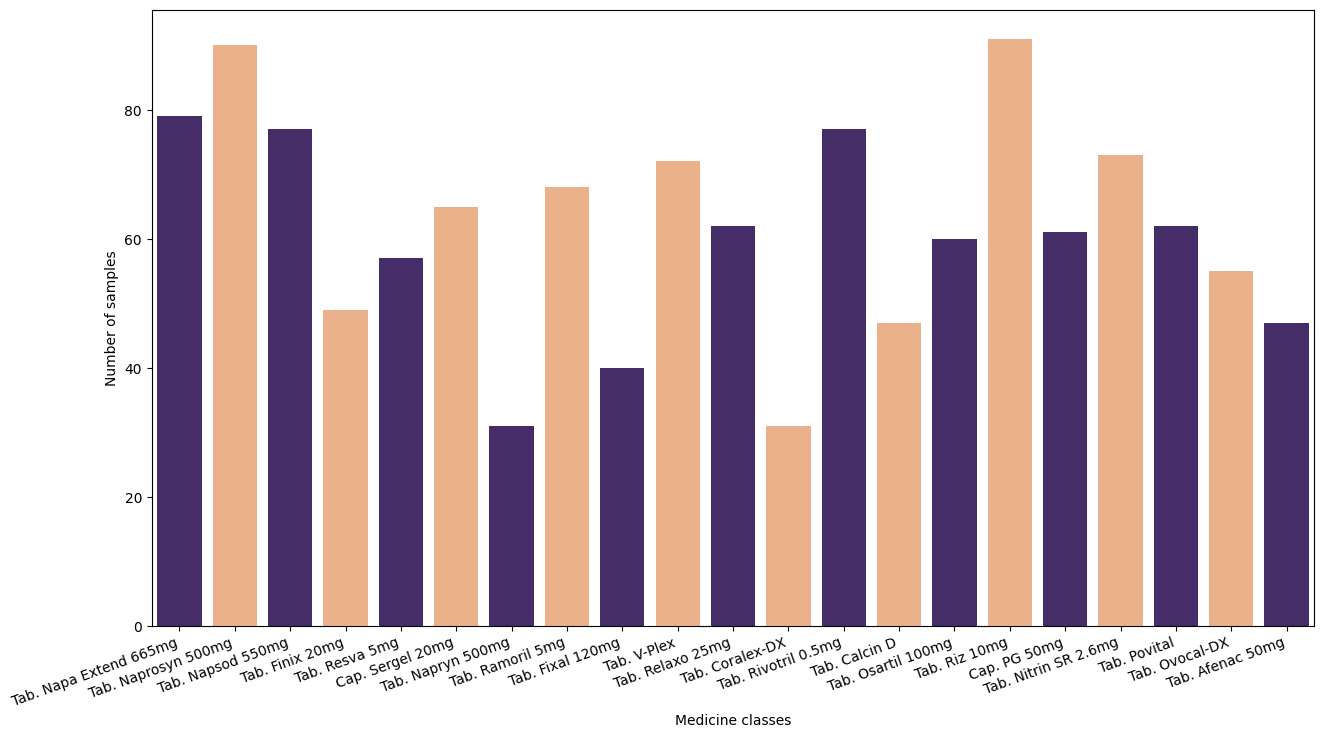

In [8]:
count_samples(df, '', True)

In [9]:
train_dataframe = df.sample(frac=0.8, random_state=random_state)
train_indices = train_dataframe.index

excluding_indices = df.index.isin(train_indices)
test_dataframe = df[~excluding_indices]

print('--Train--')
print(train_dataframe.head())
print(train_dataframe.shape)
print('--Test--')
print(test_dataframe.head())
print(test_dataframe.shape)

--Train--
               image                label
351    30_Napryn.png    Tab. Napryn 500mg
486   61_Povital.png         Tab. Povital
599  75_Rivotril.png  Tab. Rivotril 0.5mg
442   48_Osartil.png   Tab. Osartil 100mg
270       70_Riz.png        Tab. Riz 10mg
(1035, 2)
--Test--
              image                label
1   68_Naprosyn.png  Tab. Naprosyn 500mg
8      5_Napryn.png    Tab. Napryn 500mg
13    72_V-Plex.png          Tab. V-Plex
14    35_V-Plex.png          Tab. V-Plex
16    28_Relaxo.png     Tab. Relaxo 25mg
(259, 2)


In [36]:
IMG_W = 256
IMG_H = 72
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50
NO_CLASSES = 21
N_FOLD_SIZE = 5

input_shape = (IMG_H, IMG_W, CHANNELS)

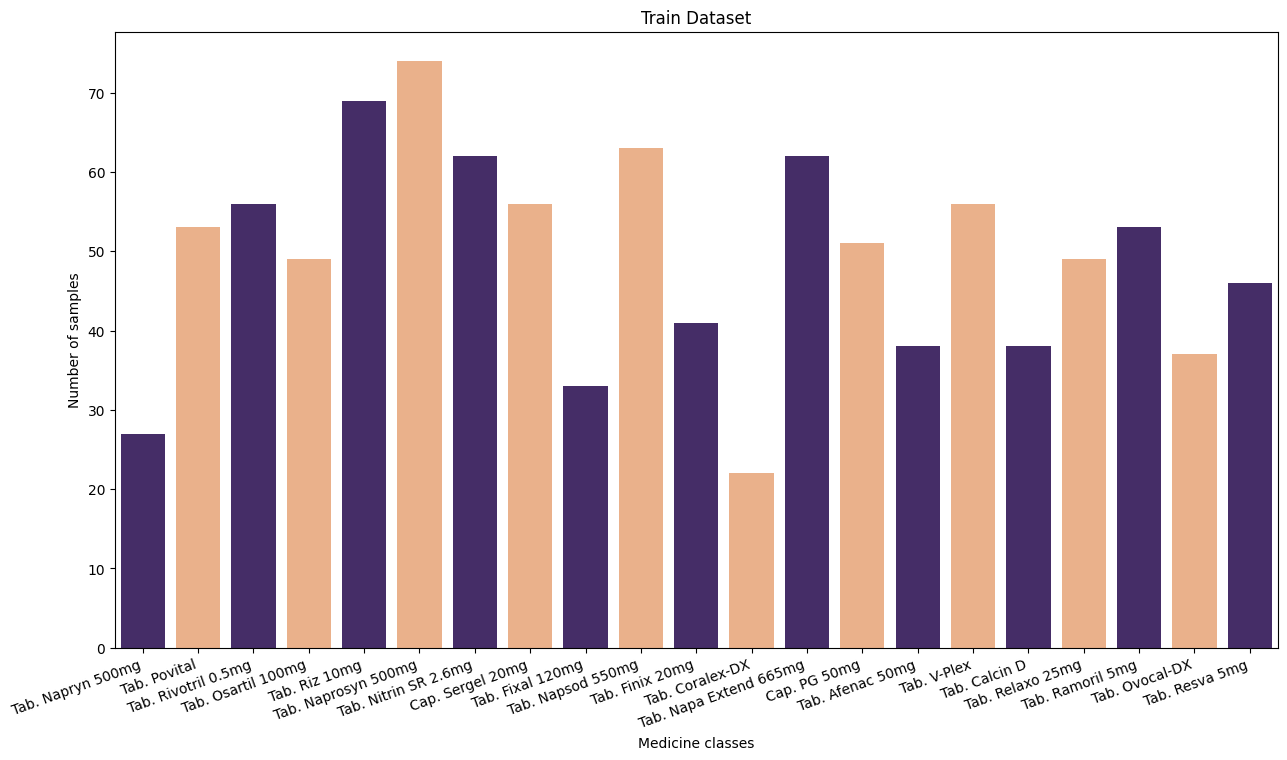

In [37]:
count_samples(train_dataframe, 'Train Dataset')

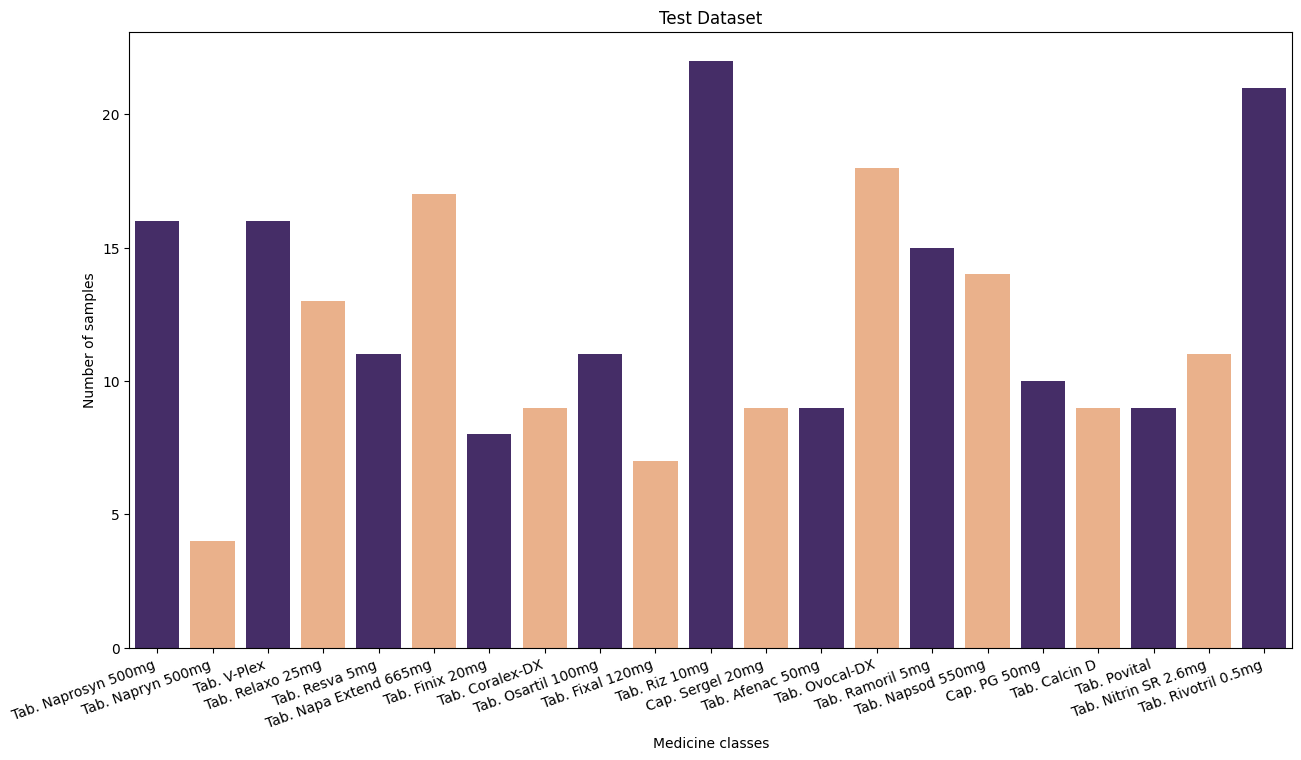

In [38]:
count_samples(test_dataframe, 'Test Dataset')

In [39]:
def plot_accuracy(history, model_name=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(25, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), acc, label='Training Accuracy')
    plt.plot(range(50), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(
        f'Training and Validation Accuracy {f"for {model_name}" if model_name else ""}')

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss')
    plt.plot(range(50), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(
        f'Training and Validation Loss {f"for {model_name}" if model_name else ""}')
    plt.savefig('./figures/model_accuracy.png')
    plt.show()

In [52]:
def create_model(no_classes):
    model = Sequential([
        # Conv 1
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        # Conv 2
        Conv2D(64,  kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 3
        Conv2D(96,  kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Conv 4
        Conv2D(96, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 5
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        # Conv 6
        Conv2D(128, (4, 4), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(no_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

## Dataset Generation and Model Training

In [53]:
datagen = ImageDataGenerator(rescale=1./255)

In [54]:
test_set = datagen.flow_from_dataframe(dataframe=test_dataframe,
            directory=dataset_path_img,
            x_col='image', y_col='label',
            class_mode='categorical',
            target_size=(IMG_H, IMG_W),
            batch_size=BATCH_SIZE)

Found 259 validated image filenames belonging to 21 classes.


In [55]:
X = train_dataframe.drop('label', axis=1)
Y = train_dataframe[['label']]

In [56]:
kfold = StratifiedKFold(n_splits=N_FOLD_SIZE, shuffle=True, random_state=random_state)

In [57]:
fold_no = 1
acc_per_fold = []

In [58]:
for train_idx, val_idx in kfold.split(X, Y):
    train_df = train_dataframe.iloc[train_idx]
    valid_df = train_dataframe.iloc[val_idx]
    print(f'Fold No. {fold_no}')

    training_set = datagen.flow_from_dataframe(dataframe=train_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    validation_set = datagen.flow_from_dataframe(dataframe=valid_df, directory=dataset_path_img,
                        x_col='image', y_col='label',
                        target_size=(IMG_H, IMG_W), batch_size=BATCH_SIZE)

    model = create_model(NO_CLASSES)
    history = model.fit(training_set, validation_data=validation_set,
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    df = pd.DataFrame(data={ 'training_acc': train_acc, 'val_acc': val_acc, 'training_loss': train_loss, 'val_loss': val_loss })
    df.to_csv(f'CNN_Model_F_{fold_no}.csv')

    model.save('model_fold_' + str(fold_no)+'.h5')

    scores = model.evaluate(test_set, verbose=0)
    test_acc = scores[1] * 100
    acc_per_fold.append(test_acc)

    print(f'Test Accuracy {test_acc}')
    print('-----'*10)

    fold_no += 1

Fold No. 1
Found 828 validated image filenames belonging to 21 classes.
Found 207 validated image filenames belonging to 21 classes.
Epoch 1/50
26/26 [==============================] - 5s 71ms/step - loss: 3.0458 - accuracy: 0.0568 - val_loss: 3.0326 - val_accuracy: 0.0725
Epoch 2/50
26/26 [==============================] - 1s 52ms/step - loss: 3.0253 - accuracy: 0.0688 - val_loss: 3.0175 - val_accuracy: 0.0725
Epoch 3/50
26/26 [==============================] - 1s 57ms/step - loss: 3.0206 - accuracy: 0.0749 - val_loss: 3.0288 - val_accuracy: 0.0676
Epoch 4/50
26/26 [==============================] - 2s 75ms/step - loss: 3.0212 - accuracy: 0.0664 - val_loss: 3.0042 - val_accuracy: 0.0676
Epoch 5/50
26/26 [==============================] - 2s 61ms/step - loss: 3.0186 - accuracy: 0.0664 - val_loss: 3.0094 - val_accuracy: 0.0725
Epoch 6/50
26/26 [==============================] - 1s 51ms/step - loss: 3.0124 - accuracy: 0.0737 - val_loss: 3.0030 - val_accuracy: 0.0725
Epoch 7/50
26/26 [===

In [59]:
for idx, acc in enumerate(acc_per_fold):
    print(f'Accuracy for fold no. {idx+1} is: {acc}')

Accuracy for fold no. 1 is: 89.18918967247009
Accuracy for fold no. 2 is: 87.25868463516235
Accuracy for fold no. 3 is: 78.76448035240173
Accuracy for fold no. 4 is: 79.53668236732483
Accuracy for fold no. 5 is: 88.03088665008545


In [60]:
acc_arr = np.array(acc_per_fold)

In [61]:
acc_mean = acc_arr.mean()
acc_mean

84.55598473548889

In [62]:
acc_std = acc_arr.std()
acc_std

4.462757831973495

In [63]:
print(f'Accuracy in between {acc_mean-acc_std} to {acc_mean+acc_std}')

Accuracy in between 80.0932269035154 to 89.01874256746238
